layer 7, epoch 10, batchsize 32,

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io


In [2]:
sst_anomaly = "/content/drive/MyDrive/mtech/project/lstm_sst_2/moored_buoy_data/bd10/water_temp_anomaly_1m.csv"
df_bonus = pd.read_csv(sst_anomaly)
df=df_bonus.iloc[1:61842,2:]#19-5-2012 3am to 18-10-2022 9 am
data=df.to_numpy()


In [ ]:
data_date=pd.read_csv('/content/drive/MyDrive/mtech/project/lstm_sst_2/moored_buoy_data/bd10/date.csv')
output1 = pd.merge(df_bonus,data_date,on='DateTime',how='inner')
dict = { 'MB Data': 'SST','Unnamed: 2': 'SST anomaly'}
 
# call rename () method
output1.rename(columns=dict,inplace=True)
  
# displaying result
rh=pd.read_csv('/content/drive/MyDrive/mtech/project/lstm_sst_2/moored_buoy_data/bd10/bd10_rh.csv')
out2=pd.merge(output1,rh,on='DateTime',how='inner')
dict={'MB Data':'Relative Humidity'}

out2.rename(columns=dict,inplace=True)
#print(out2)
#irrad=pd.read_csv('/content/drive/MyDrive/mtech/project/lstm_sst_2/moored_buoy_data/bd10/bd10_irradiance.csv')
#out3=pd.merge(out2,irrad,on='DateTime',how='inner')
#print(out3)
#dict={'MB Data':'Irradiance'}
#out3.rename(columns=dict,inplace=True)
airt=pd.read_csv('/content/drive/MyDrive/mtech/project/lstm_sst_2/moored_buoy_data/bd10/bd10_airtemp.csv')
out4=pd.merge(out2,airt,on='DateTime',how='inner')
dict={'MB Data':'Air Temp'}
out4.rename(columns=dict,inplace=True)
#print(out4)
rainfall=pd.read_csv('/content/drive/MyDrive/mtech/project/lstm_sst_2/moored_buoy_data/bd10/bd10_rainfall.csv')
out5=pd.merge(out4,rainfall,on='DateTime',how='inner')
dict={'MB Data':'Rainfall'}
out5.rename(columns=dict,inplace=True)
wind_speed=pd.read_csv('/content/drive/MyDrive/mtech/project/lstm_sst_2/moored_buoy_data/bd10/dd10_wind_speed.csv')
out6=pd.merge(out5,wind_speed,on='DateTime',how='inner')
dict={'MB Data':'Wind Speed'}
out6.rename(columns=dict,inplace=True)
#print(out6)
#wind_direction=pd.read_csv('/content/drive/MyDrive/mtech/project/lstm_sst_2/moored_buoy_data/bd10/bd10_wind_direction.csv')
#out7=pd.merge(out6,wind_direction,on='DateTime',how='inner')
#dict={'MB Data':'Wind Dir'}
#out7.rename(columns=dict,inplace=True)
print(out6)
# converting to csv
out6.to_csv('/content/drive/MyDrive/mtech/project/lstm_sst_2/moored_buoy_data/bd10/combined_1.csv')



                  DateTime        SST  SST anomaly  Relative Humidity  \
0      2012-05-19 10:00:00  30.736100    -1.883711           83.32031   
1      2012-05-19 11:00:00  30.716100    -1.863711           83.08594   
2      2012-05-19 12:00:00  30.713200    -1.860811           83.43750   
3      2012-05-19 13:00:00  30.725200    -1.872811           83.78906   
4      2012-05-19 14:00:00  30.710700    -1.858311           85.31250   
...                    ...        ...          ...                ...   
33550  2022-10-03 18:00:00  29.620972    -0.768583           82.07030   
33551  2022-10-03 21:00:00  29.588928    -0.736539           87.65630   
33552  2022-10-04 12:00:00  29.770508    -0.918119           82.92970   
33553  2022-10-04 15:00:00  29.710693    -0.858304           79.92190   
33554  2022-10-04 18:00:00  29.608154    -0.755765           76.91410   

        Air Temp  Rainfall  Wind Speed  
0      30.899658   0.05859     8.88672  
1      30.809631   0.05859     8.47656  


In [3]:
l=240#lookback
n=24#number of days predicting
data_sliced=data[0:51270,:]#slice of data; this data is from #19-5-2012 3am - 19/5/2018 3 am 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(data_sliced)
features_set = []
labels = []
for i in range(l, 51270):
    features_set.append(data_scaled[i-l:i, 0])
    labels.append(data_scaled[i, 0])
    
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1],1))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 1)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 240, 5)       140         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 240, 6)       288         ['lstm[0][0]']                   
                                                                                                  
 concatenate (Concatenate)      (None, 240, 7)       0           ['lstm_1[0][0]',                 
                                                                  'input_1[0][0]']            

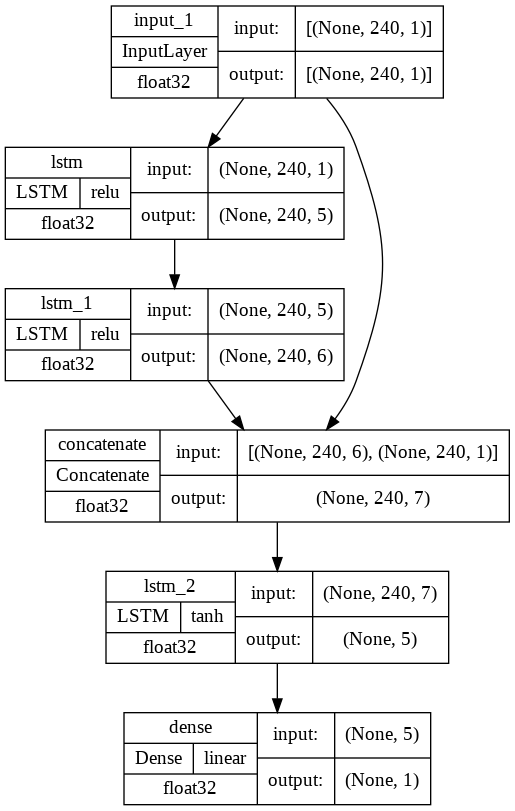

In [ ]:
# Shared Feature Extraction Layer
import tensorflow as tf
# from tf.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import concatenate
visible=Input(shape=(l,1))
extract1=LSTM(5,return_sequences=True,activation='relu')(visible)
extract2=LSTM(6,return_sequences=True,activation='relu')(extract1)
merge=concatenate([extract2,visible])
extract3=LSTM(5)(merge)
output=Dense(1)(extract3)
model=Model(inputs=visible,outputs=output)
print(model.summary())
plot_model(model, to_file='shared_feature_extractor.png',show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True)


In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [ ]:
model.fit(features_set, labels, epochs = 10, batch_size = 32)

Epoch 1/10
1595/1595 [==============================] - 1150s 716ms/step - loss: 0.0014
Epoch 2/10
1595/1595 [==============================] - 1134s 711ms/step - loss: 2.6690e-04
Epoch 3/10
1595/1595 [==============================] - 1125s 705ms/step - loss: 1.7365e-04
Epoch 4/10
1595/1595 [==============================] - 1122s 703ms/step - loss: 1.3679e-04
Epoch 5/10
1595/1595 [==============================] - 1123s 704ms/step - loss: 1.1825e-04
Epoch 6/10
1595/1595 [==============================] - 1141s 716ms/step - loss: 1.0921e-04
Epoch 7/10
1595/1595 [==============================] - 1216s 762ms/step - loss: 1.0319e-04
Epoch 8/10
1595/1595 [==============================] - 1188s 745ms/step - loss: 9.9868e-05
Epoch 9/10
1595/1595 [==============================] - 1118s 701ms/step - loss: 9.7084e-05
Epoch 10/10
1595/1595 [==============================] - 1106s 693ms/step - loss: 9.6307e-05


In [ ]:
model.save('/content/drive/MyDrive/mtech/project/lstm_sst_2/code/functional_api/timeandsst/model/sst_anomaly_l_240_v3.hdf5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
